In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

In [3]:
import pathlib
from google.colab import drive

drive.mount('/content/gdrive')
data_dir = "/content/gdrive/MyDrive/dataset_2"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/dataset_2/archive.zip -d data

Archive:  /content/gdrive/MyDrive/dataset_2/archive.zip
  inflating: data/BananaLSD/AugmentedSet/cordana/0_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/100_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/101_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/102_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/103_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/104_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/105_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/106_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/107_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/108_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/109_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/10_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/110_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/111_aug.jpeg  
  inflating: data/BananaLSD/AugmentedSet/cordana/11

In [5]:
import tensorflow as tf

In [7]:
data = tf.keras.utils.image_dataset_from_directory('/content/data/BananaLSD/AugmentedSet')
# Get the class names
class_names = data.class_names
# Print the class names
print(class_names)
len(data)

Found 1600 files belonging to 4 classes.
['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']


50

In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

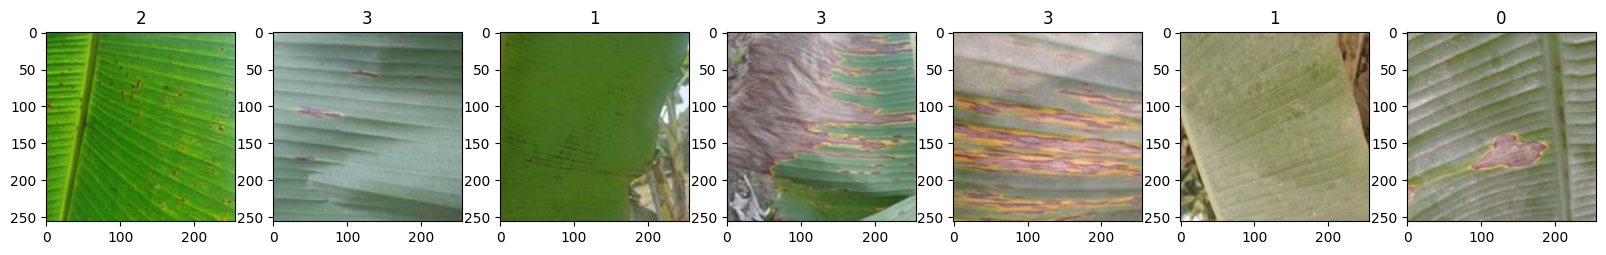

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(str(batch[1][idx]))

In [10]:
# prompt: split data above to train, test and val

def split_dataset(dataset, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
  """
  Splits a TensorFlow dataset into training, validation, and test sets.

  Args:
    dataset: The TensorFlow dataset to split.
    train_split: The proportion of the dataset to use for training.
    val_split: The proportion of the dataset to use for validation.
    test_split: The proportion of the dataset to use for testing.
    shuffle: Whether to shuffle the dataset before splitting.
    shuffle_size: The number of elements to use for shuffling.

  Returns:
    A tuple of three TensorFlow datasets: (train_dataset, val_dataset, test_dataset).
  """
  assert train_split + val_split + test_split == 1

  if shuffle:
    dataset = dataset.shuffle(shuffle_size, seed=12)

  dataset_size = len(dataset)
  train_size = int(train_split * dataset_size)
  val_size = int(val_split * dataset_size)

  train_dataset = dataset.take(train_size)
  remaining_dataset = dataset.skip(train_size)
  val_dataset = remaining_dataset.take(val_size)
  test_dataset = remaining_dataset.skip(val_size)

  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(data)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 35
Validation dataset size: 7
Test dataset size: 8


In [19]:
# prompt: make me a Resnet50 model from above

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

# Create a ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False


# Create a new model on top of the ResNet50 model
model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Build the model
# The model needs to be built before the summary can be displayed
model.build(input_shape=(None, 256, 256, 3))

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy',metrics = ['accuracy'])


In [20]:
history_resnet = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 403s 10s/step - accuracy: 0.5677 - loss: 1.1337 - val_accuracy: 0.9643 - val_loss: 0.2077
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.9391 - loss: 0.2128 - val_accuracy: 0.9777 - val_loss: 0.1341
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 403s 11s/step - accuracy: 0.9827 - loss: 0.1182 - val_accuracy: 0.9777 - val_loss: 0.1054
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 364s 10s/step - accuracy: 0.9788 - loss: 0.0976 - val_accuracy: 0.9911 - val_loss: 0.0538
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 396s 11s/step - accuracy: 0.9877 - loss: 0.0657 - val_accuracy: 0.9955 - val_loss: 0.0446
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.9952 - loss: 0.0533 - val_accuracy: 1.0000 - val_loss: 0.0451
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 354s 10s/step - accuracy: 0.9974 - loss: 0.0423 - val_accuracy: 1.0000 - val_loss: 0.0348
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 380s 10s/step - accuracy: 0.9969 - loss: 0.0381 - val_accuracy: 1.

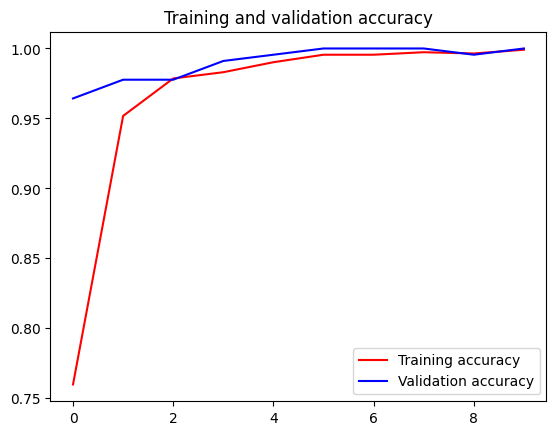

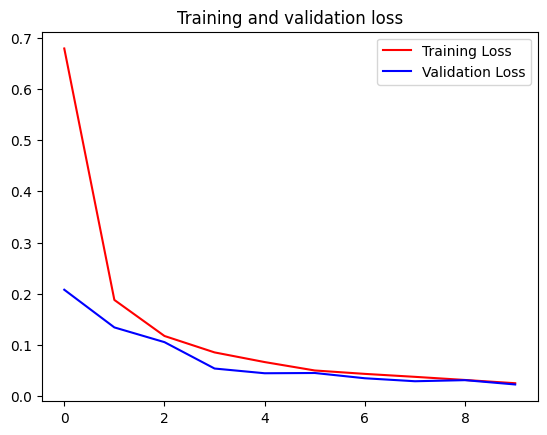

In [21]:
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
import cv2
import matplotlib

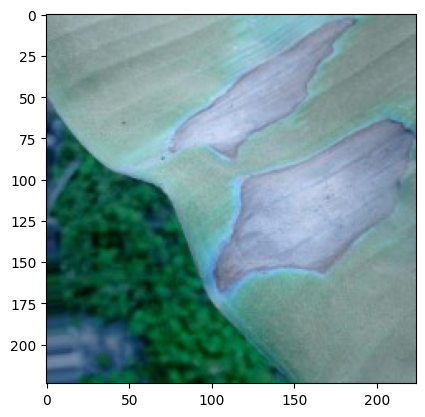

In [25]:
img = cv2.imread(r'/content/data/BananaLSD/OriginalSet/cordana/0.jpeg')

plt.imshow(img)
plt.show()

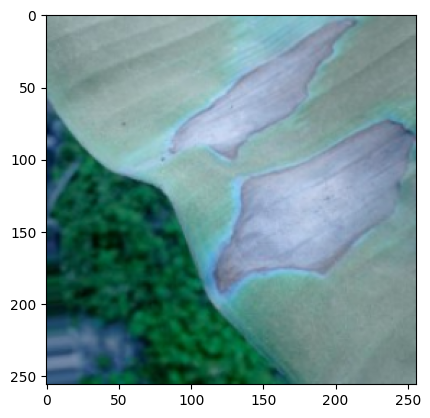

In [26]:
import numpy as np
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [27]:
# Preprocess the image
resized_image = resize / 255.0
input_image = np.expand_dims(resized_image, axis=0)

# Make predictions
yhat = model.predict(input_image)

# Get the predicted class index
predicted_class_index = np.argmax(yhat, axis=1)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index[0]]

# Get the class probabilities
class_probabilities = yhat[0]

# Print the predicted class and probabilities
print("Predicted class:", predicted_class_name)
print("Class probabilities:", class_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: sigatoka
Class probabilities: [0.00068893 0.34964624 0.01210388 0.63756096]
